In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
!unzip "/content/drive/MyDrive/datasetBV.zip" -d /content/pneumonia_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1291-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1292-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1293-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1294-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1295-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1296-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1300-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1301-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1302-0001.jpeg  
  inflating: /content/pneumonia_data/train/NORMAL/NORMAL2-IM-1303-0001.jpeg  
  i

Classify as normal, bacterial pneumonia or viral pneumonia

In [8]:
import os, shutil

def reorganize_dataset(root_dir):
    for split in ['train', 'test', 'val']:
        pneu_dir = os.path.join(root_dir, split, 'PNEUMONIA')
        bacterial_dir = os.path.join(root_dir, split, 'BACTERIAL')
        viral_dir = os.path.join(root_dir, split, 'VIRAL')

        os.makedirs(bacterial_dir, exist_ok=True)
        os.makedirs(viral_dir, exist_ok=True)

        for fname in os.listdir(pneu_dir):
            src = os.path.join(pneu_dir, fname)
            if '_bacteria_' in fname.lower():
                dst = os.path.join(bacterial_dir, fname)
            elif '_virus_' in fname.lower():
                dst = os.path.join(viral_dir, fname)
            else:
                continue
            shutil.move(src, dst)

        if not os.listdir(pneu_dir):
            os.rmdir(pneu_dir)

reorganize_dataset("/content/pneumonia_data")


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "/content/pneumonia_data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    "/content/pneumonia_data/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3577 images belonging to 3 classes.
Found 1655 images belonging to 3 classes.


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    '/content/pneumonia_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3577 images belonging to 3 classes.
Found 1655 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)


In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 11/112 ━━━━━━━━━━━━━━━━━━━━ 55s 554ms/step - accuracy: 0.4970 - loss: 1.1271

KeyboardInterrupt: 

In [43]:
model_path = '/content/drive/MyDrive/my_pneumoniaBV_model.h5'
from tensorflow.keras.models import load_model
model = load_model(model_path)
# model.summary()  # Confirm it's loaded


In [47]:
test_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # <-- FIXED HERE
)


Found 624 images belonging to 3 classes.


In [49]:
model.evaluate(test_data)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.8455 - loss: 0.4830


[0.5355587005615234, 0.8413461446762085]

In [ ]:
model.save('my_pneumoniaBV_model.h5')


In [ ]:
from google.colab import files
files.download('/content/my_pneumoniaBV_model.h5')

In [ ]:
model.summary()


In [ ]:
from google.colab import files
files.download('/content/best_model.h5')


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step


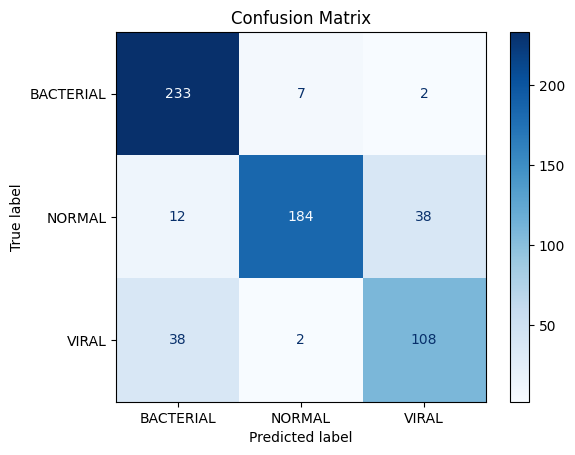


Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.82      0.96      0.89       242
      NORMAL       0.95      0.79      0.86       234
       VIRAL       0.73      0.73      0.73       148

    accuracy                           0.84       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.85      0.84      0.84       624



In [44]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels and predicted labels
y_true = []
y_pred = []

# Reset test generator before predictions
test_data.reset()


# Get predictions (probabilities)
predictions = model.predict(test_data, verbose=1)

# Convert predictions and true labels to class indices
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes  # actual class indices

# Class labels (from the directory structure)
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Optional: Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [45]:
!pip install tf-explain


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_3']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


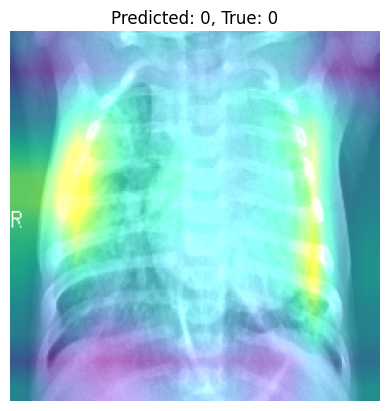

In [46]:
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
import numpy as np

# Pick one image from the test set
x_batch, y_batch = next(test_data)
image = x_batch[0:1]  # shape: (1, 224, 224, 3)
true_label = np.argmax(y_batch[0])

# Get prediction
pred = model.predict(image)
predicted_class = np.argmax(pred)

# Run Grad-CAM with target layer specified
explainer = GradCAM()
explanation = explainer.explain(
    validation_data=(image, None),
    model=model,
    class_index=predicted_class,
    layer_name="block5_conv3"  # specify last conv layer in VGG16
)

# Show Grad-CAM result
plt.imshow(explanation)
plt.title(f"Predicted: {predicted_class}, True: {true_label}")
plt.axis('off')
plt.show()



What You're Seeing

Bright/colored regions (yellow/red): Areas the model focused on when making its prediction.

Cooler regions (blue/green): Less important or ignored by the model.

The background is the original X-ray image, but overlaid with this "importance map" as a semi-transparent layer.





